# Simple Convolutional Neural Network on MNIST

This notebook accompanies the subsection on **Convolutional Neural Networks (CNNs)** in
Chapter 4 of the *Mathematics of Generative AI* living book.

We will:

- Load the MNIST handwritten-digit dataset.
- Define a small **ConvNet** with two convolutional layers and one fully connected head.
- Train the network using **cross-entropy loss** and a gradient-based optimizer.
- Visualize:
  - sample input images,
  - the training and test curves (loss and accuracy),
  - a few **misclassified** digits.

The figures generated here are saved under `figs/` and referenced in the LaTeX text as:
- `figs/cnn_mnist_examples.png`
- `figs/cnn_mnist_train_curves.png`
- `figs/cnn_mnist_misclassified.png`

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

# Make sure a directory for figures exists
os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 1. MNIST Dataset and DataLoaders

We use the standard MNIST dataset of $28\times28$ grayscale digit images ($0$--$9$).

Each image is:

- converted to a PyTorch tensor,
- normalized to have mean $\approx 0.1307$ and standard deviation $\approx 0.3081$,
  which are the standard MNIST statistics.

We then create training and test data loaders with mini-batches.

In [2]:
# Standard MNIST normalization values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)

(60000, 10000)

### Sample MNIST Digits

We visualize a small batch of training images and their labels. This figure will be used in
the book to illustrate the input domain for the CNN.

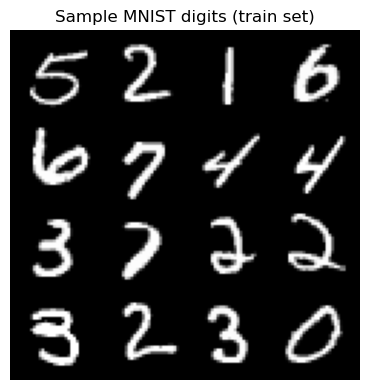

Labels for displayed digits: [5 2 1 6 6 7 4 4 3 7 2 2 3 2 3 0]


In [3]:
# Get one batch of images
images, labels = next(iter(train_loader))

# Denormalize for visualization
mean, std = 0.1307, 0.3081
images_vis = images * std + mean

grid = utils.make_grid(images_vis[:16], nrow=4, padding=2)
plt.figure(figsize=(4, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Sample MNIST digits (train set)")
plt.tight_layout()
plt.savefig("figs/cnn_mnist_examples.png", dpi=300, bbox_inches="tight")
plt.show()

print("Labels for displayed digits:", labels[:16].numpy())

## 2. A Simple CNN Architecture

We now define a small convolutional network with:

- **Conv layer 1**: $1 \to 16$ channels, $3\times3$ kernels, padding 1 (keeps $28\times28$).
- **MaxPool 1**: $2\times2$ pooling, reducing spatial size to $14\times14$.
- **Conv layer 2**: $16 \to 32$ channels, $3\times3$ kernels, padding 1 (keeps $14\times14$).
- **MaxPool 2**: $2\times2$ pooling, reducing spatial size to $7\times7$.
- **Fully connected head**: flatten $7\times7\times32$ to a vector of size 1568,
  then `Linear(1568, 128)` + ReLU, and `Linear(128, 10)` for class logits.

This is exactly the architecture described in the LaTeX example.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: (N, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # After two 2x2 pools: spatial size 28 -> 14 -> 7
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv + ReLU + pool
        x = self.pool(F.relu(self.conv1(x)))
        # Second conv + ReLU + pool
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully connected head
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 3. Training with Cross-Entropy Loss and SGD/Adam

We train the CNN using:

- **Cross-entropy loss**, appropriate for multi-class classification.
- The **Adam** optimizer (a practical variant of SGD with adaptive step sizes).

We track both loss and accuracy on the training and test sets across epochs.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

### Training Loop

We train for a small number of epochs (e.g., 3--5) to obtain a reasonable accuracy without
making the notebook too slow to run. We record the training and test loss/accuracy at each
epoch.

In [6]:
n_epochs = 3

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:2d}/{n_epochs}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}%, "
          f"test_loss={test_loss:.4f}, test_acc={test_acc*100:.2f}%")

Epoch  1/3: train_loss=0.1673, train_acc=94.86%, test_loss=0.0594, test_acc=97.87%
Epoch  2/3: train_loss=0.0481, train_acc=98.52%, test_loss=0.0386, test_acc=98.79%
Epoch  3/3: train_loss=0.0344, train_acc=98.89%, test_loss=0.0356, test_acc=98.72%


## 4. Training and Test Curves

We now plot:

- training vs test **loss**,
- training vs test **accuracy**,

as functions of the epoch index. This figure is used in the text to illustrate the
optimization dynamics of CNN training on MNIST.

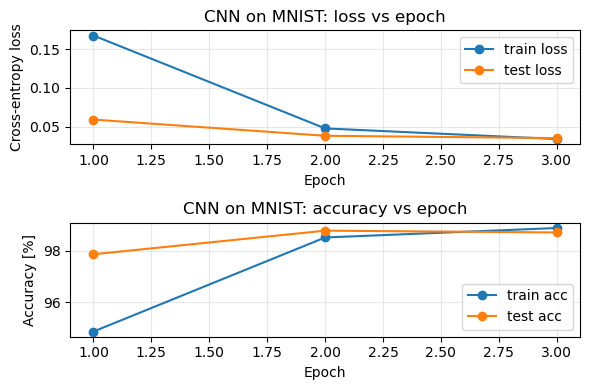

In [7]:
import numpy as np

epochs = np.arange(1, n_epochs + 1)

plt.figure(figsize=(6, 4))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, marker="o", label="train loss")
plt.plot(epochs, test_losses, marker="o", label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("CNN on MNIST: loss vs epoch")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(epochs, np.array(train_accuracies) * 100, marker="o", label="train acc")
plt.plot(epochs, np.array(test_accuracies) * 100, marker="o", label="test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.title("CNN on MNIST: accuracy vs epoch")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figs/cnn_mnist_train_curves.png", dpi=300, bbox_inches="tight")
plt.show()

## 5. Inspecting Misclassified Digits

To better understand the limitations of the model, we visualize a few **misclassified**
test images along with their true and predicted labels.

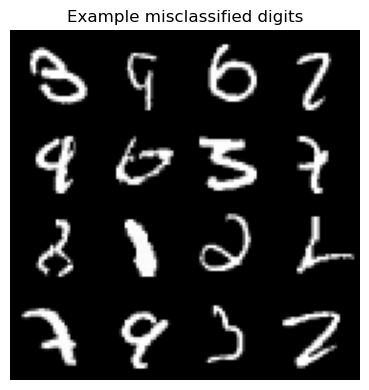

True labels:      [3, 9, 6, 2, 9, 6, 3, 7, 8, 1, 2, 2, 7, 9, 3, 2]
Predicted labels: [8, 5, 0, 7, 8, 0, 5, 3, 2, 8, 3, 4, 3, 8, 5, 7]


In [8]:
model.eval()
mis_images = []
mis_true = []
mis_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, dim=1)
        mism = predicted != labels
        if mism.any():
            idxs = torch.nonzero(mism).squeeze().cpu().tolist()
            if isinstance(idxs, int):
                idxs = [idxs]
            for idx in idxs:
                mis_images.append(images[idx].cpu())
                mis_true.append(labels[idx].cpu().item())
                mis_pred.append(predicted[idx].cpu().item())
                if len(mis_images) >= 16:
                    break
        if len(mis_images) >= 16:
            break

if mis_images:
    # Denormalize for visualization
    mis_stack = torch.stack(mis_images)
    mis_vis = mis_stack * 0.3081 + 0.1307

    from torchvision import utils as vutils
    grid = vutils.make_grid(mis_vis, nrow=4, padding=2)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Example misclassified digits")
    plt.tight_layout()
    plt.savefig("figs/cnn_mnist_misclassified.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("True labels:     ", mis_true)
    print("Predicted labels:", mis_pred)
else:
    print("No misclassified examples found in the sampled test set (unlikely with few epochs).")

## 6. Discussion

This simple CNN on MNIST illustrates the key ideas from the chapter:

- **Local receptive fields and weight sharing** let the network exploit the 2D structure
  of images while using far fewer parameters than a fully connected network of comparable
  width.
- **Cross-entropy loss** combined with mini-batch stochastic optimization (Adam/SGD)
  provides an effective training procedure.
- Even such a small CNN achieves strong performance on MNIST, yet the misclassified
  digits remind us that the learned representation is not perfect and that data quality,
  architecture, and optimization all play a role.

In later chapters, we will see how these principles extend to deeper convolutional
architectures (e.g., ResNets) and how they relate to more general sequence-processing
models (e.g., Transformers) that use different inductive biases in place of convolutions.
